## Загрузка датасета

In [1]:
!python --version

Python 3.12.1


In [2]:
import os
import sys
sys.path.append('C:/Users/Vlad/A4-OCR-Intro/task2')

In [3]:
import lmdb
from data_reader import Vocabulary, HWDBDatasetHelper, LMDBReader
import cv2
import numpy as np

In [9]:
root = 'D:/data'
train_path = os.path.join(root, 'train.lmdb')
test_path = os.path.join(root, 'test.lmdb')
gt_path = 'C:/Users/Vlad/A4-OCR-Intro/task2/gt.txt'

In [5]:
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

In [6]:
train_helper, val_helper = train_helper.train_val_split()

In [7]:
train_helper.size(), val_helper.size()

(2578433, 644609)

In [8]:
img, label = train_helper.get_item(42)

In [9]:
img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

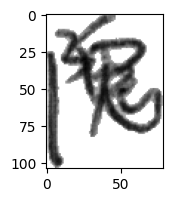

In [10]:
from matplotlib import pyplot as plt
plt.figure(figsize=(2, 2))
plt.imshow(img, cmap='gray')

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

class HWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper):
        self.helper = helper
    
    def __len__(self):
        return self.helper.size()
    
    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)
        return (cv2.resize(img, (32, 32))[np.newaxis, :] - 127.5) / 255., label

In [12]:
train_dataset = HWDBDataset(train_helper)
val_dataset = HWDBDataset(val_helper)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=2048, drop_last=True, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=0)

## Архитектура модели & цикл обучения

In [14]:
!pip install -qq pytorch_lightning

In [15]:
!pip install -qq torchinfo lightning

Представленная далее архитектура является упрощённой версией модели, описанной в статье "Deep Convolutional Network for Handwritten Chinese Character Recognition" by Yuhao Zhang: http://cs231n.stanford.edu/reports/2015/pdfs/zyh_project.pdf

In [16]:
import pytorch_lightning as pl
import torchmetrics
from lightning.pytorch.loggers import TensorBoardLogger

In [17]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [18]:
device

'cuda:0'

In [19]:
NUM_CLASSES = train_helper.vocabulary.num_classes()

In [20]:
class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, NUM_CLASSES)

        self.loss_func = nn.CrossEntropyLoss()

        self.train_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.test_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=NUM_CLASSES)



    def forward(self, x):
        x = x.type(torch.FloatTensor).to(device)
        x = self.backbone(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        pred = self.forward(x)
        loss = self.loss_func(pred, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

        self.train_acc(pred, y)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        pred = self.forward(x)
        loss = self.loss_func(pred, y)
        pred = torch.argmax(pred, dim=1)
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

        self.test_acc(pred, y)
        self.log('test_acc', self.test_acc, on_step=False, on_epoch=True, prog_bar=True)
        output = dict({
            'test_loss': loss,
            'test_acc': self.test_acc,
        })
        return output

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)
        return [optimizer], [scheduler]

In [42]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [46]:
model = Model().to(device)
logger = TensorBoardLogger("tb_logs", name="Experiment 1")
trainer = pl.Trainer(logger=logger, accelerator="gpu", max_epochs=20, limit_train_batches=200)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [44]:
trainer.test(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │  0.00017064607527572662   │
│         test_loss         │     8.899843215942383     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 8.899843215942383, 'test_acc': 0.00017064607527572662}]

In [47]:
trainer.fit(model, train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | backbone  | Sequential         | 878 K 
1 | fc1       | Linear             | 13.1 M
2 | fc2       | Linear             | 15.0 M
3 | loss_func | CrossEntropyLoss   | 0     
4 | train_acc | MulticlassAccuracy | 0     
5 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
29.0 M    Trainable params
0         Non-trainable params
29.0 M    Total params
116.027   Total estimated model params size (MB)
C:\Users\Vlad\miniconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

In [146]:
trainer.test(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8224629163742065     │
│         test_loss         │    0.6981706619262695     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6981706619262695, 'test_acc': 0.8224629163742065}]

In [151]:
trainer.save_checkpoint("C:/Users/Vlad/A4-OCR-Intro/exp_1_epoch_20.ckpt")

Обучим модель ещё на 10 эпохах.

P.S. Не успел сделать... Половину баллов жалко терять.

### Evaluation

In [32]:
model = Model.load_from_checkpoint('C:/Users/Vlad/A4-OCR-Intro/exp_1_epoch_20.ckpt').to(device)

In [21]:
pred_path = 'C:/Users/Vlad/A4-OCR-Intro/task2/pred.txt'

test_reader = LMDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')

In [23]:
test_dataset = HWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=0)

In [29]:
from tqdm import tqdm

In [33]:
preds = []
model.eval()
with torch.no_grad():
    for X, _ in tqdm(test_loader):
        logits = model(X.to(torch.float32).cuda())
        classes = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(classes)

100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [01:37<00:00,  3.91it/s]


In [42]:
with open(pred_path, 'w', encoding="utf-8") as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)

In [4]:
import course_intro_ocr_t2.evaluate

ModuleNotFoundError: No module named 'course_intro_ocr_t2'

In [12]:
from pathlib import Path

def evaluate(gt_path, pred_path):
    gt = dict()
    with open(gt_path, encoding="utf-8") as gt_f:
        for line in gt_f:
            name, cls = line.strip().split()
            gt[name] = cls

    n_good = 0
    n_all = len(gt)
    with open(pred_path, encoding="utf-8") as pred_f:
        for line in pred_f:
            name, cls = line.strip().split()
            if cls == gt[name]:
                n_good += 1

    return n_good / n_all

In [13]:
evaluate(gt_path, pred_path)

0.7315005479554373